# Identify Shotgun Submissions

### June 8th 2014 Neil Lawrence

#### Updated May 2021

Shotgun submissions are mutliple submissions from a similar set of authors. These submissions should be identified so that, in the worst case, they can be rejected outright, or they can be allocated to the same area chair who can be made aware of the issue. This script reads in a paper list downloaded from CMT and does an analysis of the shotgun submissions. It makes use of `nltk` for stemming.

In [1]:
import cmtutils.cmtutils as cu
import nltk
import numpy as np
import pandas as pd
import pylab as pb

#nltk.download() --- required at first time of running.

Load in latest list of papers.

In [2]:
filename = '2014-06-08_paper_list.xls'
cmt = cu.cmt_papers_read(filename=filename)

Abstract summary words for title, authors and abstracts.

In [3]:
words = {'title':{}, 'author':{}, 'abstract':{}, 'keywords':{}}
for id in cmt.papers.index:
    #if int(id) < 1000:
    words['abstract'][id] = cu.extract_stem_words(cmt.papers['Abstract'][id])
    words['title'][id] = cu.extract_stem_words(cmt.papers['Title'][id])
    words['author'][id] = [author.strip() for author in cmt.papers['AuthorEmails'][id].split(';')]
    words['keywords'][id] = [keyword.strip().replace('*', '') for keyword in cmt.papers['SubjectAreas'][id].split(';')]

Construct similarity matrices by matching across the word lists (would be quicker and more sensible to tokenize to do this). 

In [43]:
num_papers = len(cmt.papers.index)
S = {}
for key in words.keys():
    S[key] = pd.DataFrame(np.zeros((num_papers, num_papers)), 
                 index=cmt.papers.index, 
                 columns=cmt.papers.index)

for id1 in cmt.papers.index:
    for id2 in cmt.papers.index:
        if int(id2) > int(id1):
            break
        for key in S.keys():
            result = len(set(words[key][id1]) & set(words[key][id2]))
            S[key][id1][id2] = result
            S[key][id2][id1] = result            

Normalize the similarities so that the diagonal is set to 1.

In [47]:
nS = {}
for key in S:
    D = np.sqrt(np.diag(S[key]))
    nS[key] = S[key]/D
    nS[key] = (nS[key].T/D).T

Set a threshold for how close is a match. Go through the similarities and find all abover threshold abstract scores where there is a non-zero author overlap. 

In [48]:
thresh = 0.3
duplicates = []
string = []
url_stem = 'https://cmt.research.microsoft.com/NIPS2014/Protected/Chair/ViewSubmissionDetails.aspx?paperId='
for id in cmt.papers.index:
    dup_list = nS['abstract'][id][nS['abstract'][id]>thresh]
    if len(dup_list)>1:
        for id2 in dup_list.index:
            if not id2 == id:
                if int(id) < int(id2):
                    author_overlap = nS['author'][id][id2]
                    if author_overlap>0:
                        #print 'Potential Duplicate Papers'
                        #print 'Abstract overlap', dup_list[id2], 'and author overlap', author_overlap
                        #print 'https://cmt.research.microsoft.com/NIPS2014/Protected/Chair/ViewSubmissionDetails.aspx?paperId=' + id
                        #print 'https://cmt.research.microsoft.com/NIPS2014/Protected/Chair/ViewSubmissionDetails.aspx?paperId=' + id2
                        #print
                        #duplicates.append([id, id2, dup_list[id2]])
                        string.append([id, id2, str(dup_list[id2]), '', 
                                       url_stem + id, 
                                       url_stem + id2,
                                       cmt.papers['Title'][id],
                                       cmt.papers['Title'][id2],
                                       cmt.papers['AuthorNames'][id].encode('utf8'),
                                       cmt.papers['AuthorNames'][id2].encode('utf8')])

Write the information about shotgun matches in a CSV file for sharing with Corinna.

In [46]:
import csv
import os
with open(os.path.join(cu.cmt_data_directory, "shotgun_submissions.csv"), 'w') as f:
    wr = csv.writer(f)
    wr.writerows(string)


Histogram of scores to make sure threshold of similarity is falling somewhere sensible.

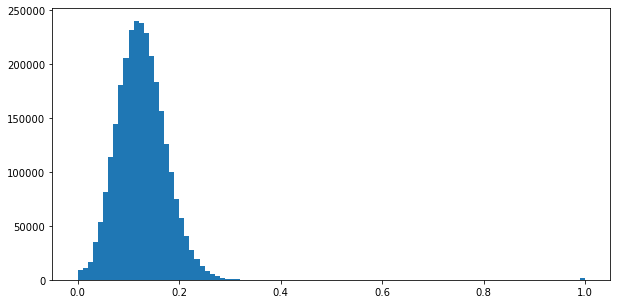

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(nS['abstract'].values.flatten(), range=[0, 1], bins=100)


## Loading Corinna's Matches

Corinna independently was also testing for shotgun papers. She'd saved her top 40 matches to file. Here we load them in and do a comparison. Then we save a combined file.

In [ ]:
matches = pd.read_csv(os.path.join(cmtutils.cmt_data_directory, 'top_40_matches.csv'), header=0)
for ind in matches.index:
    id1 = str(matches['id1'][ind])
    id2 = str(matches['id2'][ind])
    #id2 = '2'
    matches.loc[ind, 'score'] =  nS['abstract'][id1][id2]
matches.to_csv(os.path.join(cmtutils.cmt_data_directory, 'top_40_matches_scores.csv'))

### Exploring the Papers

Finally, just to get an idea of what's going on we compute the similarities between papers and project them onto their principal components for visualisation.

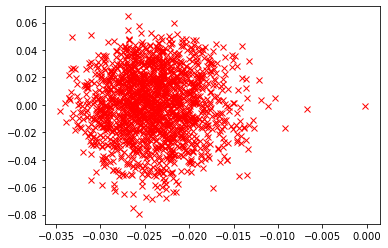

In [55]:
import matplotlib.pyplot as plt

v, u = np.linalg.eig(nS['abstract'])
plt.plot(u[:, 0], u[:, 1], 'rx')
plt.show()

Place principal components in a data frame.

In [56]:
PCs = pd.DataFrame(u*v, index=cmt.papers.index, 
                   columns=['PC' + str(i) for i in np.arange(u.shape[0])])

Sort by first principal component and show the leading paper titles.

In [ ]:
sind = PCs.sort_values(by='PC0').index
cmt.papers['Title'][sind]

Plot first two principal components of data.

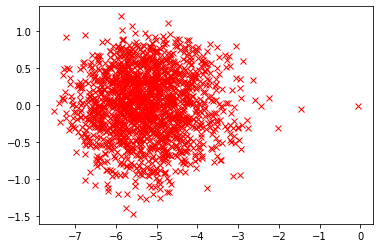

In [62]:
_ = plt.plot(PCs.values[:, 0], PCs.values[:, 1], 'rx')
